# 1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline

# Set the random seed
random_seed = 2
num_classes = 19
epochs = 7 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 64

np.random.seed(random_seed)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2. Data preparation

In [2]:
train = pd.read_csv("D:\\Ahmed\\AI\\OCR-master\\data\\emnist\\processed_balanced_train_filtered_mapped.csv")
test = pd.read_csv("D:\\Ahmed\\AI\\OCR-master\\data\\emnist\\processed_balanced_test_filtered_mapped.csv")

In [3]:
Y_train = train["label"] #Y = labels
Y_test = test["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"], axis = 1)  #X = data
X_test = test.drop(labels = ["label"], axis = 1)

In [4]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1) # 1 for grayscale
X_test = X_test.values.reshape(-1,28,28,1)


Y_train = to_categorical(Y_train, num_classes = num_classes) #turn labels into one-hot encoding
Y_test = to_categorical(Y_test, num_classes = num_classes)


In [5]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

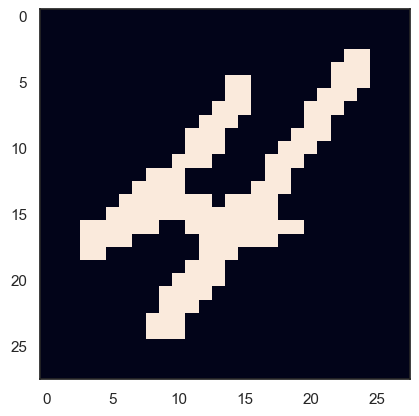

In [6]:
# Some examples
g = plt.imshow(X_train[10][:,:,0])

# 3. CNN
## 3.1 Define the model

In [12]:

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 80, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 32)        16416     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 80)          23120     
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 80)         

## 3.2 Set the optimizer and annealer

In [13]:

# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## 3.3 Data augmentation 

In [14]:

datagen = ImageDataGenerator(
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

datagen.fit(X_train)

In [15]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, callbacks=[learning_rate_reduction])

Epoch 1/7


C:\Users\ahmed\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


642/642 - 45s - loss: 0.4905 - accuracy: 0.8498 - val_loss: 0.1294 - val_accuracy: 0.9640 - lr: 0.0010 - 45s/epoch - 70ms/step
Epoch 2/7
642/642 - 42s - loss: 0.1859 - accuracy: 0.9422 - val_loss: 0.1050 - val_accuracy: 0.9678 - lr: 0.0010 - 42s/epoch - 66ms/step
Epoch 3/7
642/642 - 42s - loss: 0.1504 - accuracy: 0.9530 - val_loss: 0.0892 - val_accuracy: 0.9748 - lr: 0.0010 - 42s/epoch - 66ms/step
Epoch 4/7
642/642 - 44s - loss: 0.1314 - accuracy: 0.9586 - val_loss: 0.0880 - val_accuracy: 0.9741 - lr: 0.0010 - 44s/epoch - 68ms/step
Epoch 5/7

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
642/642 - 44s - loss: 0.1160 - accuracy: 0.9635 - val_loss: 0.0901 - val_accuracy: 0.9739 - lr: 0.0010 - 44s/epoch - 69ms/step
Epoch 6/7
642/642 - 44s - loss: 0.0935 - accuracy: 0.9703 - val_loss: 0.0780 - val_accuracy: 0.9803 - lr: 5.0000e-04 - 44s/epoch - 69ms/step
Epoch 7/7
642/642 - 44s - loss: 0.0915 - accuracy: 0.9702 - val_loss: 0.0789 - val_accuracy: 0.9781 - lr: 5

# 4. Evaluate the model
## 4.1 Training and validation curves

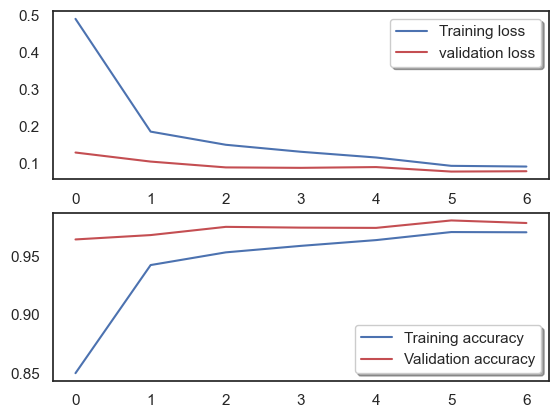

In [16]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

143/143 [==============================] - 1s 8ms/step


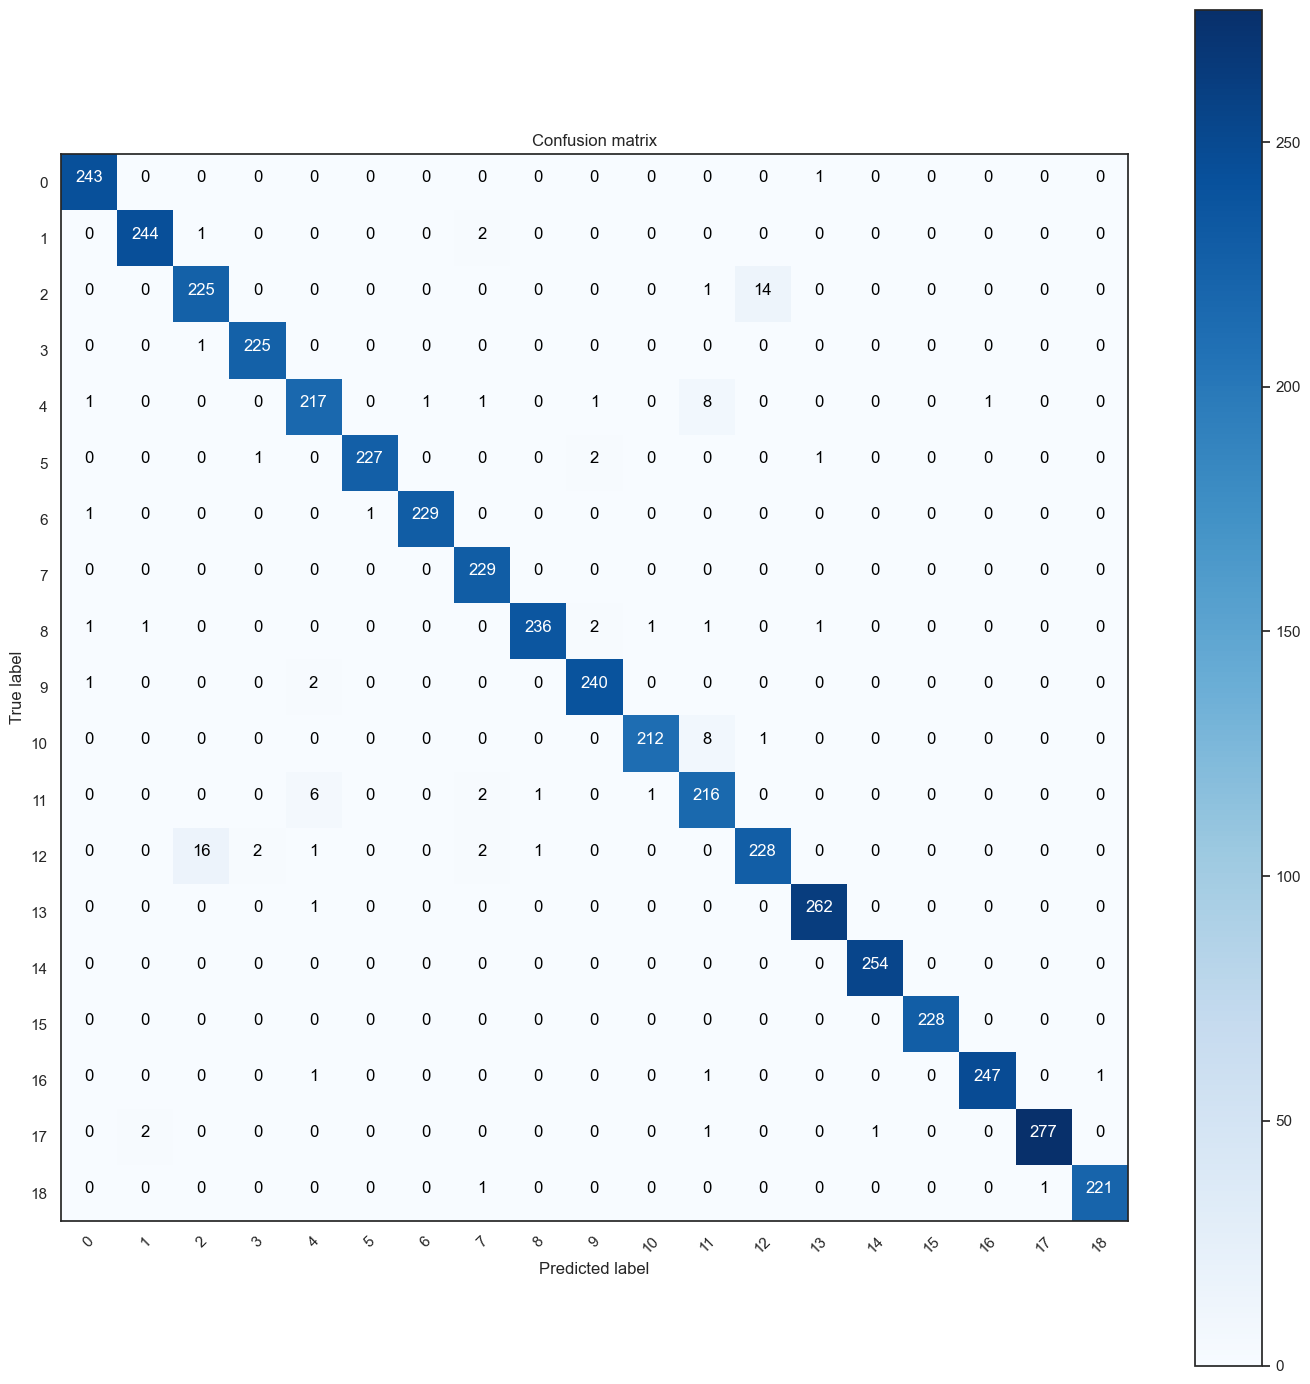

In [17]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix

figure(figsize=(14, 14))
plot_confusion_matrix(confusion_mtx, classes = range(num_classes)) 

In [19]:
# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

Y_test = np.argmax(Y_test,axis = 1) 
conf_mat = confusion_matrix(results, Y_test)
acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
print('Overall accuracy: {} %'.format(acc*100))

238/238 [==============================] - 2s 8ms/step
Overall accuracy: 97.86842105263159 %


## Save the model

In [20]:
model.save('D:\Ahmed\AI\OCR-master\model\modelOCR4.h5')